# Sprawozdanie z **Obliczeń ewolucyjnych**
## Zadanie 2 

In [2]:
!pip install deap > /dev/null
!pip install matplotlib > /dev/null
!pip install tabulate > /dev/null
# !pip install k3d > /dev/null
%matplotlib notebook

<div>Setting plot style to hide unused header</div>
<style>
div.ui-dialog-titlebar.ui-widget-header {display: none;}
</style>

## Configuration

### Imports

In [116]:
from tabulate import tabulate
from IPython.display import display
import itertools
import math
import operator
import random
from statistics import mean
import time

import numpy
np = numpy
from deap import base
from deap.benchmarks import movingpeaks
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)

In [118]:
from pathlib import Path
import json

class Config(object): 
    def __init__(self, TYPE, CHI, C, P, DIST, DIMS, NSWARMS, NPARTICLES, NEXCESS, RCLOUD, EVALS):
        self.CHI = CHI        
        self.TYPE = TYPE
        self.C = C
        self.P = P
        self.DIST = DIST
        self.DIMS = DIMS
        self.NSWARMS = NSWARMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD
        self.EVALS = EVALS

def as_config(dct):
    return Config(
        dct['TYPE'],        
        dct['CHI'],
        dct['C'],
        dct['P'],
        dct['DIST'],
        dct['DIMS'],
        dct['NSWARMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        dct['EVALS'],
        )

def tabulate_config():
    display(tabulate([[cfg.CHI, cfg.TYPE, cfg.C, cfg.P, cfg.DIST, cfg.DIMS, cfg.NSWARMS, cfg.NPARTICLES, cfg.NEXCESS, cfg.RCLOUD]],
                     headers=["CHI", "TYPE", "C", "P", "DIST", "DIMS", "NSWARMS", "NPARTICLES", "NEXCESS", "RCLOUD"],
                     tablefmt="html"))

### Plots

In [55]:
flatten = lambda l: [item for sublist in l for item in sublist]
figsize = (14, 8)
def annot_min(x,y, ax=None, x_pos_mod=1, y_pos_mod=-0.06):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.5,-0.02), **kw)

def hist_over_time(result_book, single_gen_index=None,
                   min_hist_value=1, sift_rate=2,
                   skip_first=100, limits=(-250, 70)):
    hists = result_book.select("hist")
    hists = hists[skip_first:] # skip first 100 evals
    hists = hists[0::sift_rate] # take one in 4
    hists = [h for h in hists if h]
    all_z_points = flatten([a[0].tolist() for a in hists])
    all_x_points = flatten([((a[1][1:] + a[1][:-1])/2).tolist() for a in hists])
    all_y_points = flatten([np.full(len(x[1]), x[0]) for x in [(a,hists[a][0]) for a in range(len(hists))]])
    size =  len(all_z_points)
    p = 0
    while p < size:
        if all_z_points[p] < min_hist_value:
            del all_z_points[p]
            del all_x_points[p]
            del all_y_points[p]
            size = size - 1
            p = p - 1
        p = p + 1
    fig = plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes(projection="3d", title="Value of particles fitness's histogram across generations (in Z)")
    ax.scatter3D(all_x_points, all_y_points, all_z_points, c=all_z_points, cmap='inferno');
    ax.set_xlim(limits[0], limits[1])
    plt.show()

    if single_gen_index:
        res = np.array(result_book.select("hist")[single_gen_index])
        z_points = res[0]
        x_points = (res[1][1:] + res[1][:-1])/2
        print(x_points)
        y_points = np.zeros(len(z_points))
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        print(f"{len(z_points)} = {len(x_points)} = {len(y_points)}")
        ax.scatter3D(x_points, y_points, z_points, c=y_points, cmap='inferno');
        plt.show()
        
def plots_nswarms(result_book, top_limit=10):
    swarms = result_book.select("nswarm")
    swarms = [s for s in swarms]
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Number of swarms across generations")
    ax.set_ylim(0, top_limit)
    ax.scatter(range(len(swarms)), swarms, c=swarms, cmap='copper');
    plt.show()

def plot_titled(y, ax, title):
    ax.set_title(title)
    ax.scatter(range(len(y)), y, c=y, cmap='coolwarm');
    annot_min(range(len(y)), y, ax=ax)
    plt.show()

def plot_offline_error(result_book):
    off_error = result_book.select("offline_error")
    off_error = np.array(off_error)

    fig = plt.figure(figsize=figsize, dpi=55)
    ax = plt.axes(title="Offline error across generations")
    ax.scatter(range(len(off_error)), off_error, c=off_error, cmap='coolwarm');
    annot_min(range(len(off_error)), off_error)
    plt.show()

def plot_error(result_book):
    error = result_book.select("error")
    error = np.array(error)
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Error across generations")
    # ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
    ax.plot(range(len(error)), error)
    annot_min(range(len(error)), error)
    plt.show()

# Algorytmy MPSO, MSPSO oraz BOA

### Creator

In [119]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    best=None, bestfit=creator.FitnessMax)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMax)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

### Update particles

In [120]:
def convertQuantum(swarm, rcloud, centre, dist):
    dim = len(swarm[0])
    for part in swarm:
        position = [random.gauss(0, 1) for _ in range(dim)]
        dist = math.sqrt(sum(x**2 for x in position))
        
        if dist == "gaussian":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "uvd":
            u = random.random()
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "nuvd":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u / dist) + c for x, c in zip(position, centre)]
        
        del part.fitness.values
        del part.bestfit.values
        part.best = None
    
    return swarm

def updateParticleMPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

def updateParticleMSPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]
    
def updateEliteParticles(population):
    for updateSwarm in population:
        lbest = [swarm[0] for swarm in population if swarm != updateSwarm]
        mean = np.mean(lbest, axis=0)
        N = nrand.uniform(1, 2, len(updateSwarm.best))
        updateSwarm[0][:] = list(map(operator.mul,
                           mean,
                           N))
from math import pow
def updateParticleBOA(rand_part_1, rand_part_2, part, best, c, a, p):
    r = random.uniform(0, 1)
    fragrance = c*(pow(part.fitness.values[0], a))
    r1 = (r**2 * rand_part_1[i] - rand_part_2[i] for i in range(len(part)))
    if r < p:
        move = map(operator.mul,
                map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(r**2),
                                    best),
                    part),
                itertools.repeat(fragrance))
    else:
        move = map(operator.mul,
                   itertools.repeat(fragrance),
                   r1)
    part[:] = list(map(operator.add, part, move))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

### Toolbox

In [121]:
def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    if cfg.TYPE == "MPSO":
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "MSPSO":
        toolbox.register("update", updateParticleMSPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "BOA":
        toolbox.register("update", updateParticleBOA, p=cfg.P)
    else:
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    toolbox.register("convert", convertQuantum, dist=cfg.DIST)
    toolbox.register("evaluate", mpb)
    toolbox.register("eliteupdate", updateEliteParticles)
    return toolbox

### Algorithms bodies in App class

In [122]:
class App():
    def register_stats(self, should_plot):
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        logbook = tools.Logbook()
        if should_plot:
            stats.register("hist", lambda a: numpy.histogram(a, bins="auto"))
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max", "hist"
        else:
            logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"
        return stats, logbook
    def boa(self, should_plot):
        # Single swarm only
        cfg.NPARTICLES, cfg.NSWARMS = cfg.NPARTICLES*cfg.NSWARMS, 1
        c, a = 0.01, 0.1
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Update and evaluate the swarm
            for swarm in population:
                swarm.best = None
                for part in swarm:
                    part.fitness.values = toolbox.evaluate(part)
                    # Update global best
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                for part in swarm:
                    toolbox.update(random.choice(swarm), random.choice(swarm), part, swarm.best, c, a)

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)
            a=a+(0.025/(a*generation))
            generation += 1
        return logbook

    def mspso(self, should_plot):
        verbose=False
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            elite_part_index = None
            for i, part in enumerate(swarm):
                part.fitness.values = toolbox.evaluate(part)
                # Find elite particle
                if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                    elite_part_index = i
                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness
            swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        if verbose:
            print(logbook.stream)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            toolbox.eliteupdate(population)
            
            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values
                elite_part_index = None
                for i, part in enumerate(swarm):
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best and i != 0:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)
                    # Find elite particle
                    if not elite_part_index or swarm[elite_part_index].bestfit < part.bestfit:
                        elite_part_index = i
                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values
                swarm[0], swarm[elite_part_index] = swarm[elite_part_index], swarm[0]
            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

            if verbose:
                print(logbook.stream)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook
    def mpso(self, should_plot):
        verbose=True
        scenario = movingpeaks.SCENARIO_1
        global BOUNDS
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats(should_plot)

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]
        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        generation = 1
        while mpb.nevals < cfg.EVALS:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            not_converged = 0
            worst_swarm_idx = None
            worst_swarm = None
            for i, swarm in enumerate(population):
                # Compute the diameter of the swarm
                for p1, p2 in itertools.combinations(swarm, 2):
                    d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                    if d > 2*rexcl:
                        not_converged += 1
                        # Search for the worst swarm according to its global best
                        if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                            worst_swarm_idx = i
                            worst_swarm = swarm
                        break

            # If all swarms have converged, add a swarm
            if not_converged == 0:
                population.append(toolbox.swarm(n=cfg.NPARTICLES))
            # If too many swarms are roaming, remove the worst swarm
            elif not_converged > cfg.NEXCESS:
                population.pop(worst_swarm_idx)

            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values

                for part in swarm:
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook
    def run(self, should_plot=True):
        start_time = time.time()
        result = None
        if cfg.TYPE == "MPSO":
            result = self.mpso(should_plot)
        elif cfg.TYPE == "MSPSO":
            result = self.mspso(should_plot)
        elif cfg.TYPE == "BOA":
            result = self.boa(should_plot)
        else:
            result = self.mpso(should_plot)
        if should_plot:
            plot_results(result)
        return result, (time.time() - start_time)
def plot_results(logbook):
        hist_over_time(logbook)
        plots_nswarms(logbook, top_limit=cfg.NSWARMS*2)
        plot_offline_error(logbook)
        plot_error(logbook)

def plot_means_from_runs(runs, names):
    fig, axes = plt.subplots(len(names), 1, sharex=True, figsize=(10,8))
    for i, col_name in enumerate(names):
        min_len = np.min([len(v[0].select(col_name)) for v in runs])
        values = [x[0].select(col_name)[0:min_len] for x in runs]
        mean_values = np.mean(values, axis=0)
        plot_titled(mean_values, axes[i], f"Mean {col_name} across generations taken from {len(runs)} runs")

def run_n_times(n):
    tabulate_config()
    results = [App().run(should_plot=False) for _ in range(n)]
    print("--- Mean computation time %.4f seconds ---" % np.mean([x[1] for x in results]))
    print("--- Mean offline error %.4f ---" % np.mean(flatten(x[0].select("offline_error") for x in results)))
    plot_means_from_runs(results, ["offline_error", "error"])

# Test runs

Konfiguracja wspólna dla wszystkich testów
* n_runs - ilość uruchomień danego algorytmu w ramach jednego testu

In [123]:
n_runs = 2

#### Offline error
Podstawową miarą zastosowaną do oceny jakości algorytmów jest tzw. "offline error", który jest popularną metryką stosowaną w problemach o dynamicznych warunkach. Przeprowadzono 30 iteracji każdego algorytmu, aby wybrać na potrzeby dalszych kroków jeden z algorytmów

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MPSO,2.05,0.8,nuvd,5,1,3,1,0.5


--- Mean computation time 1.6283 seconds ---
--- Mean offline error 22.5348 ---


<IPython.core.display.Javascript object>

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MPSO,2.05,0.8,nuvd,5,1,5,1,0.5


--- Mean computation time 1.6658 seconds ---
--- Mean offline error 6.2336 ---


<IPython.core.display.Javascript object>

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MPSO,2.05,0.8,nuvd,1,1,5,1,0.5


--- Mean computation time 1.1754 seconds ---
--- Mean offline error 0.3141 ---


<IPython.core.display.Javascript object>

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MPSO,2.05,0.8,nuvd,20,1,25,1,0.5


--- Mean computation time 4.4966 seconds ---
--- Mean offline error 56.8792 ---


<IPython.core.display.Javascript object>


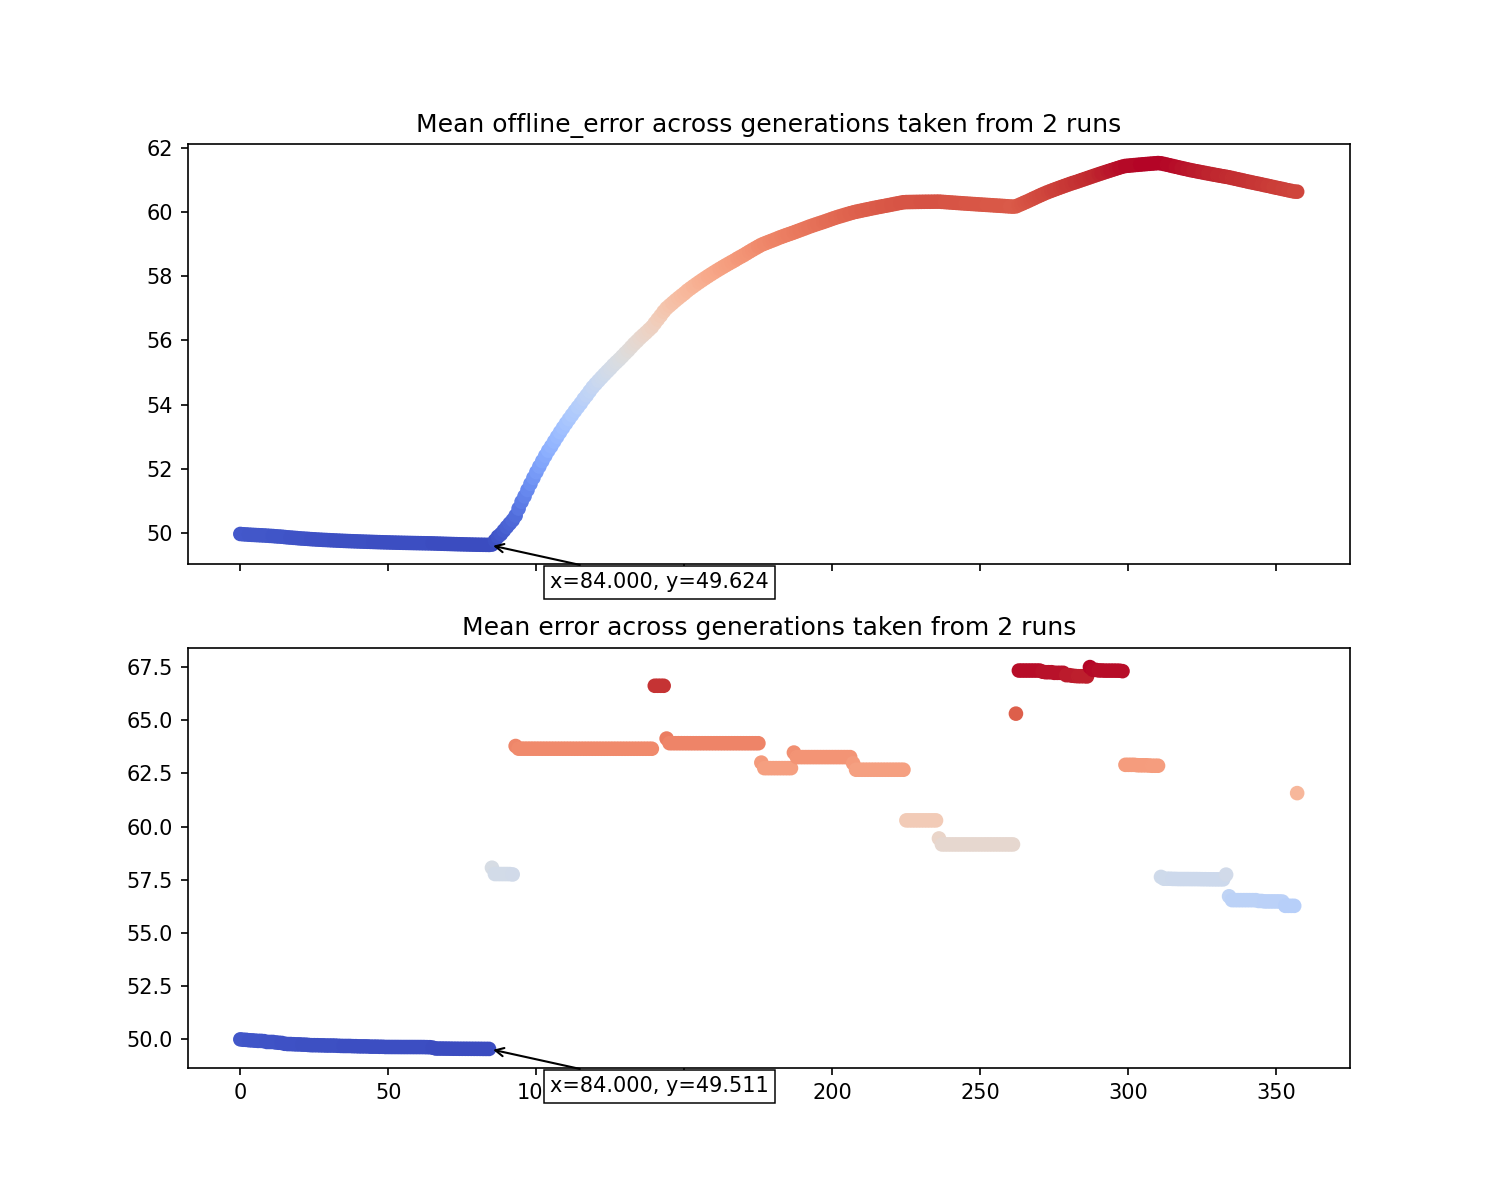

In [111]:
json_config ="""
{
    "TYPE": "MPSO",
    "CHI": 0.729843788,
    "C": 2.05,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 1,
    "NPARTICLES": 3,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 50000,
    "P": 0.8
}"""
cfg = json.loads(json_config, object_hook = as_config)
run_n_times(n_runs)
cfg.NPARTICLES = 5
run_n_times(n_runs)

cfg.DIMS = 1
run_n_times(n_runs)
cfg.DIMS = 5

cfg.NSWARMS = 5
run_n_times(n_runs)
cfg.NSWARMS = 1

cfg.NEXCESS = 3
run_n_times(n_runs)
cfg.NEXCESS = 1

cfg.RCLOUD = 1
run_n_times(n_runs)
cfg.RCLOUD = 0.5

cfg.CHI = 0.6
run_n_times(n_runs)
cfg.CHI = 0.729843788

In [112]:
-------------------------------------------------------------------------------------

SyntaxError: invalid syntax (<ipython-input-112-1431316f0588>, line 1)

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,5,5,3,1,0.5


--- Mean computation time 2.6240 seconds ---
--- Mean offline error 38.2538 ---


<IPython.core.display.Javascript object>


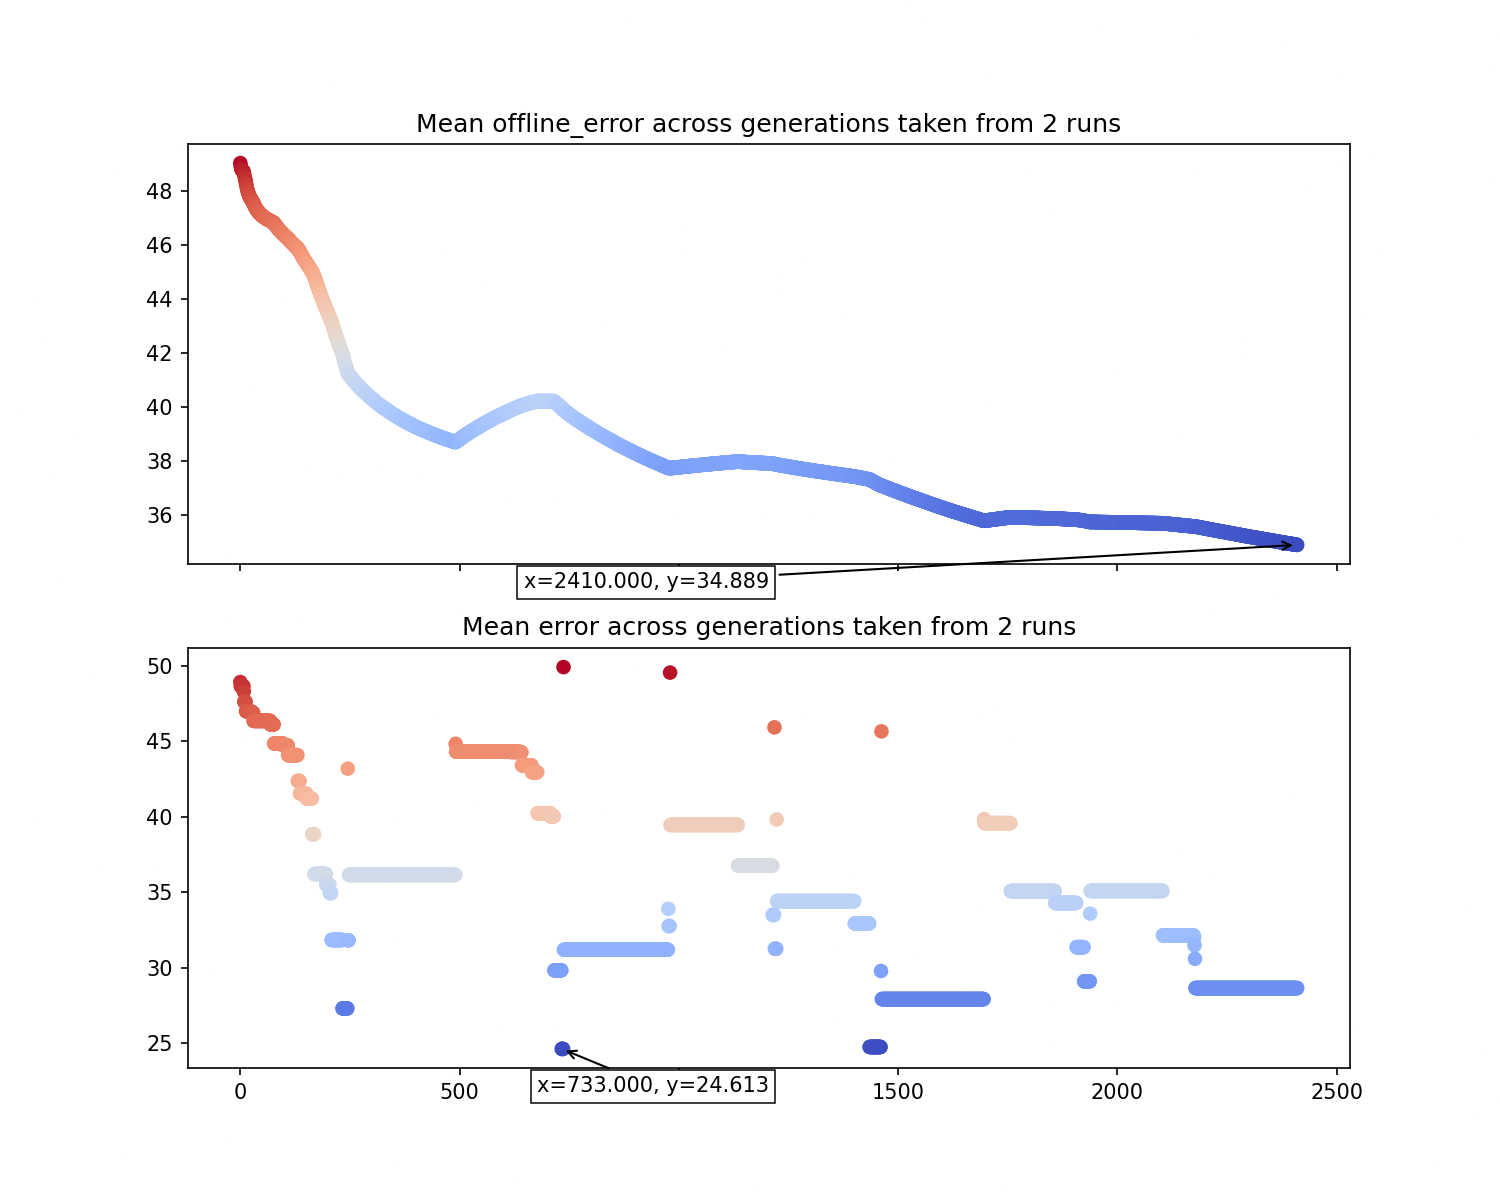

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,5,5,5,1,0.5


--- Mean computation time 2.4871 seconds ---
--- Mean offline error 20.1244 ---


<IPython.core.display.Javascript object>


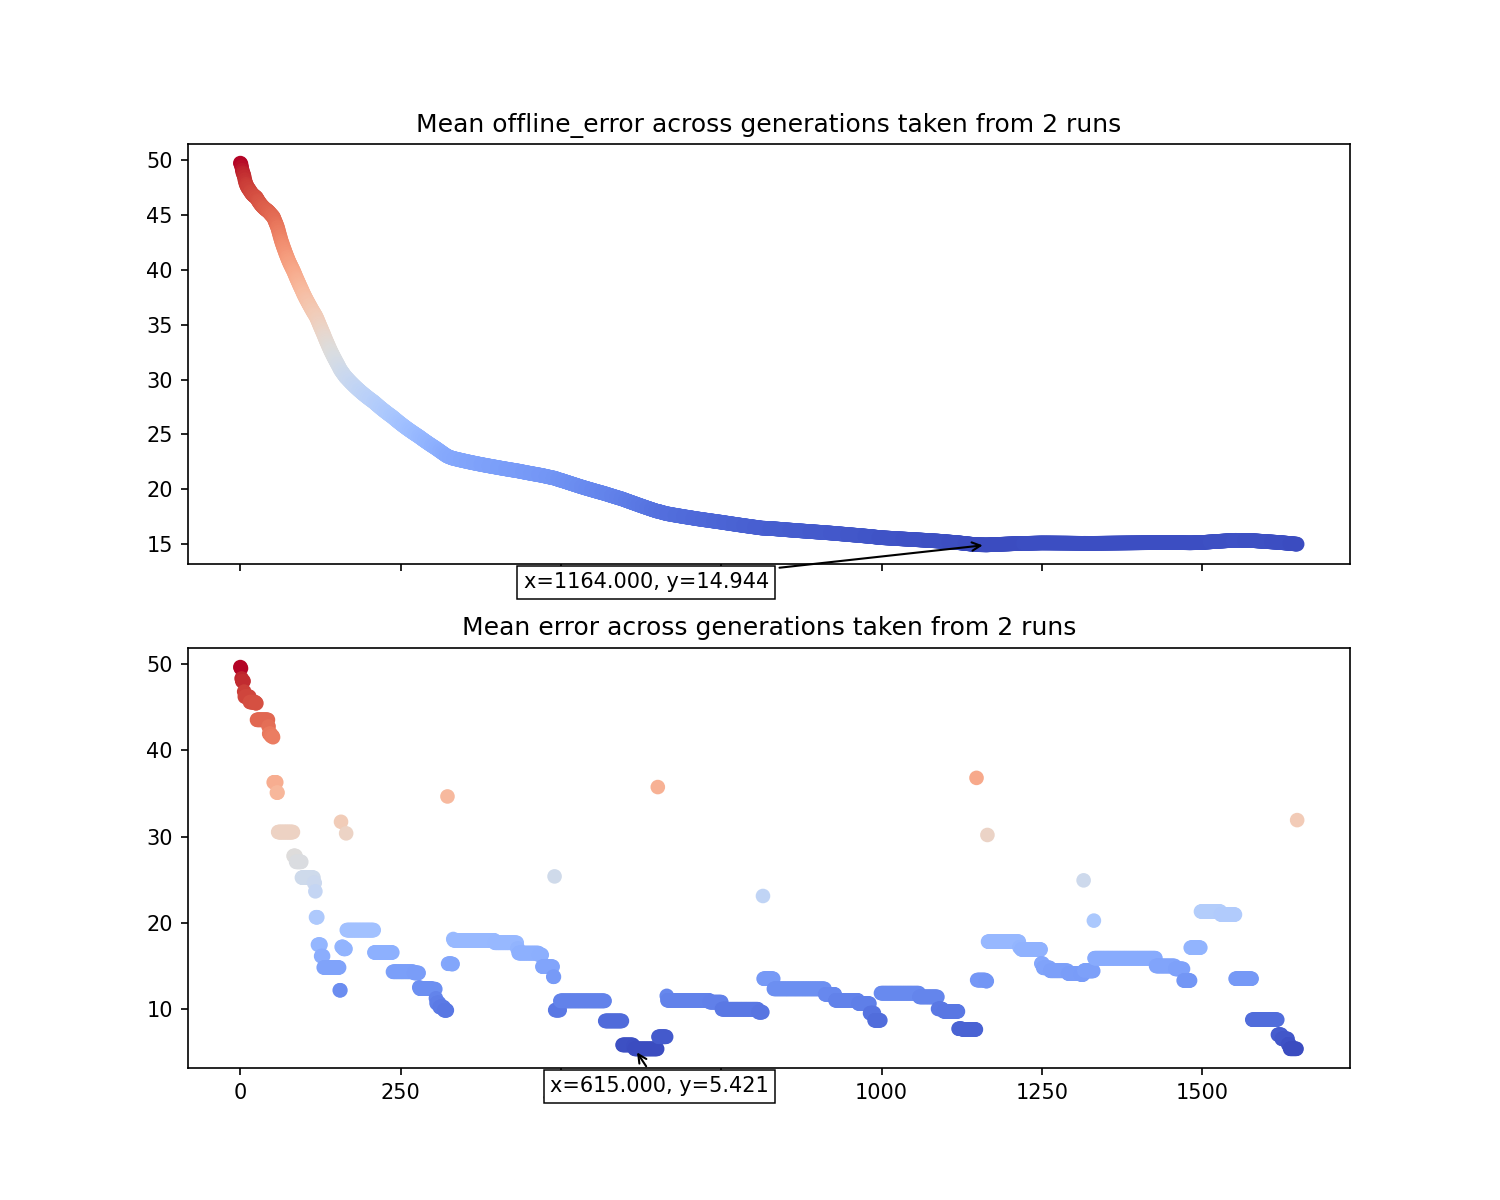

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,1,5,5,1,0.5


--- Mean computation time 1.5427 seconds ---
--- Mean offline error 0.1336 ---


<IPython.core.display.Javascript object>


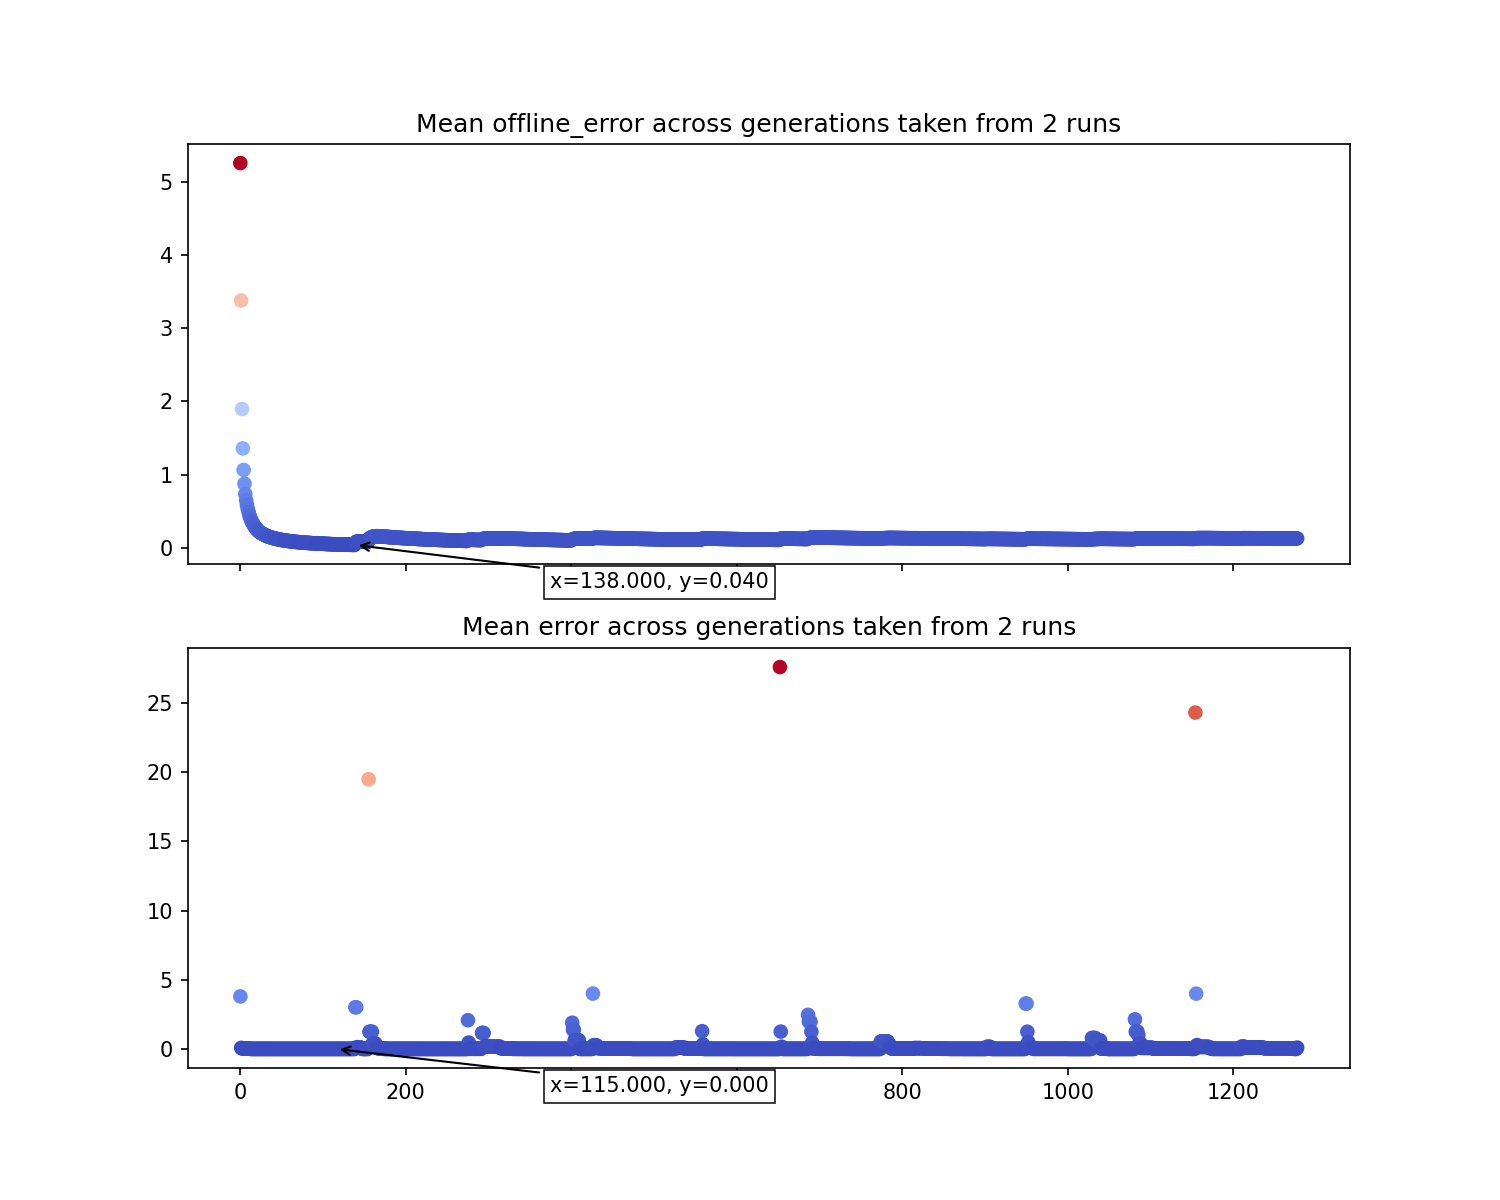

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,5,10,5,1,0.5


--- Mean computation time 2.4849 seconds ---
--- Mean offline error 33.3563 ---


<IPython.core.display.Javascript object>


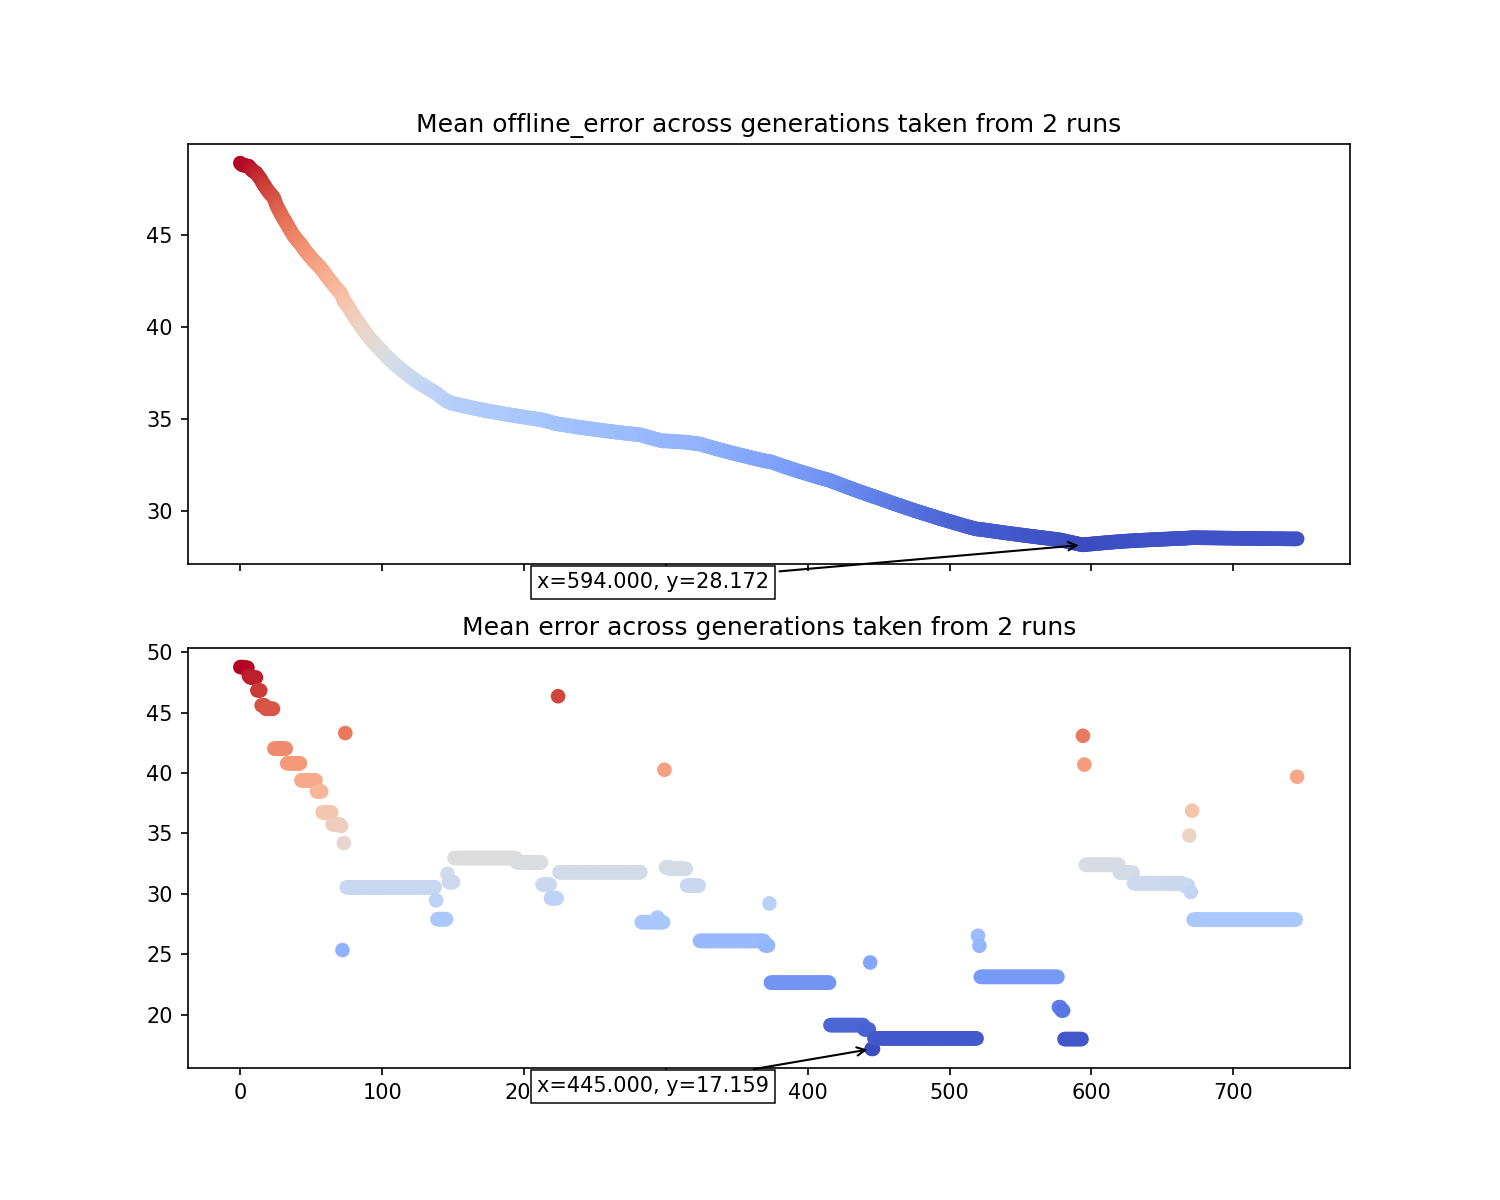

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,5,5,5,3,0.5


--- Mean computation time 2.5334 seconds ---
--- Mean offline error 18.8245 ---


<IPython.core.display.Javascript object>


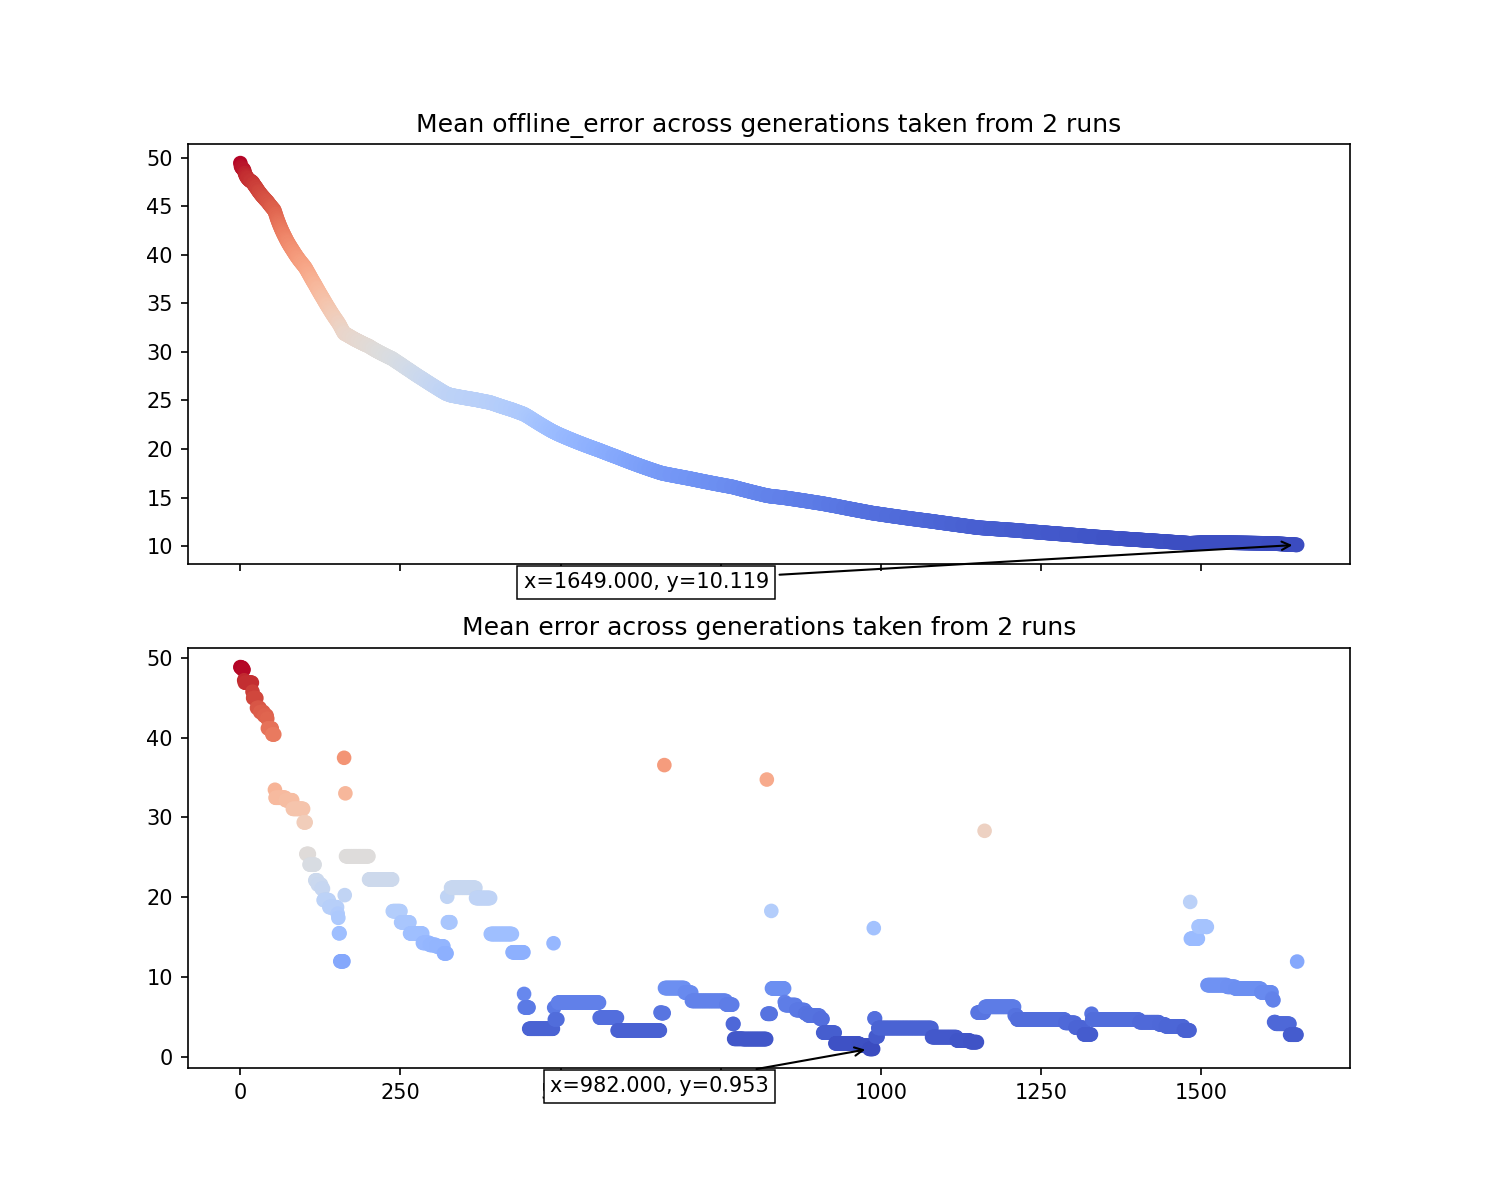

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.729844,MSPSO,2.05,0.8,nuvd,5,5,5,1,1


--- Mean computation time 2.5766 seconds ---
--- Mean offline error 20.4402 ---


<IPython.core.display.Javascript object>


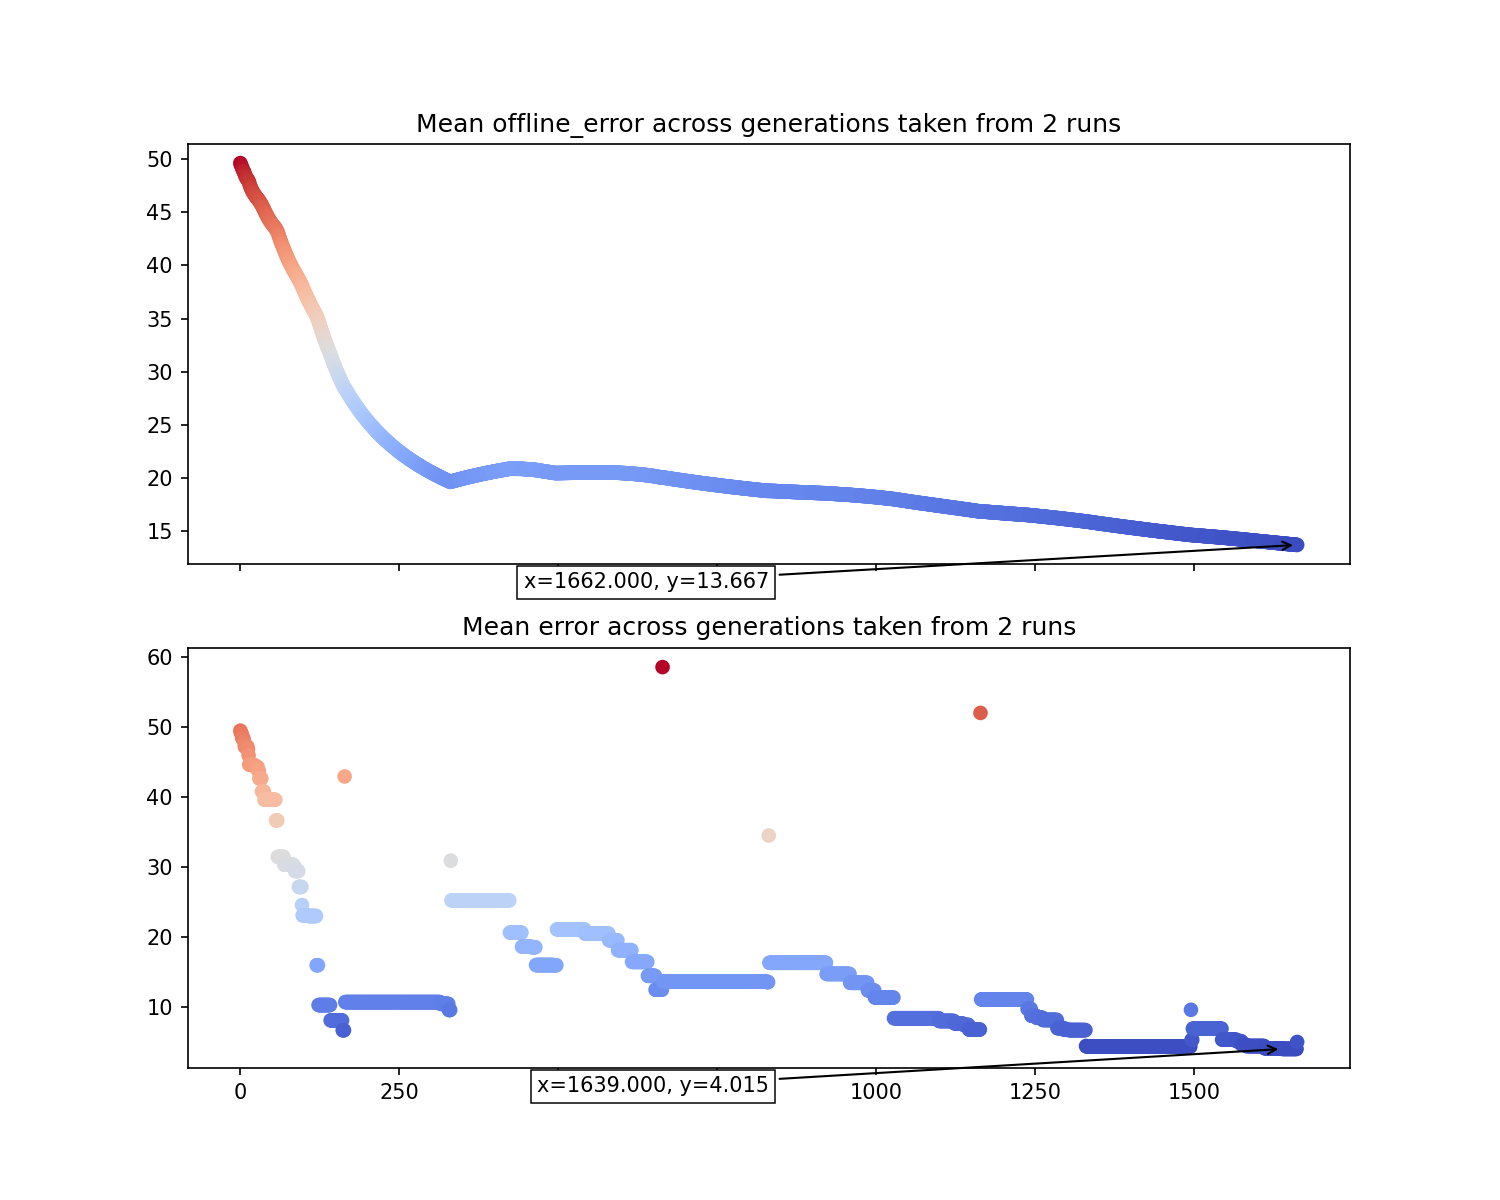

CHI,TYPE,C,P,DIST,DIMS,NSWARMS,NPARTICLES,NEXCESS,RCLOUD
0.6,MSPSO,2.05,0.8,nuvd,5,5,5,1,0.5


--- Mean computation time 2.5252 seconds ---
--- Mean offline error 12.5229 ---


<IPython.core.display.Javascript object>


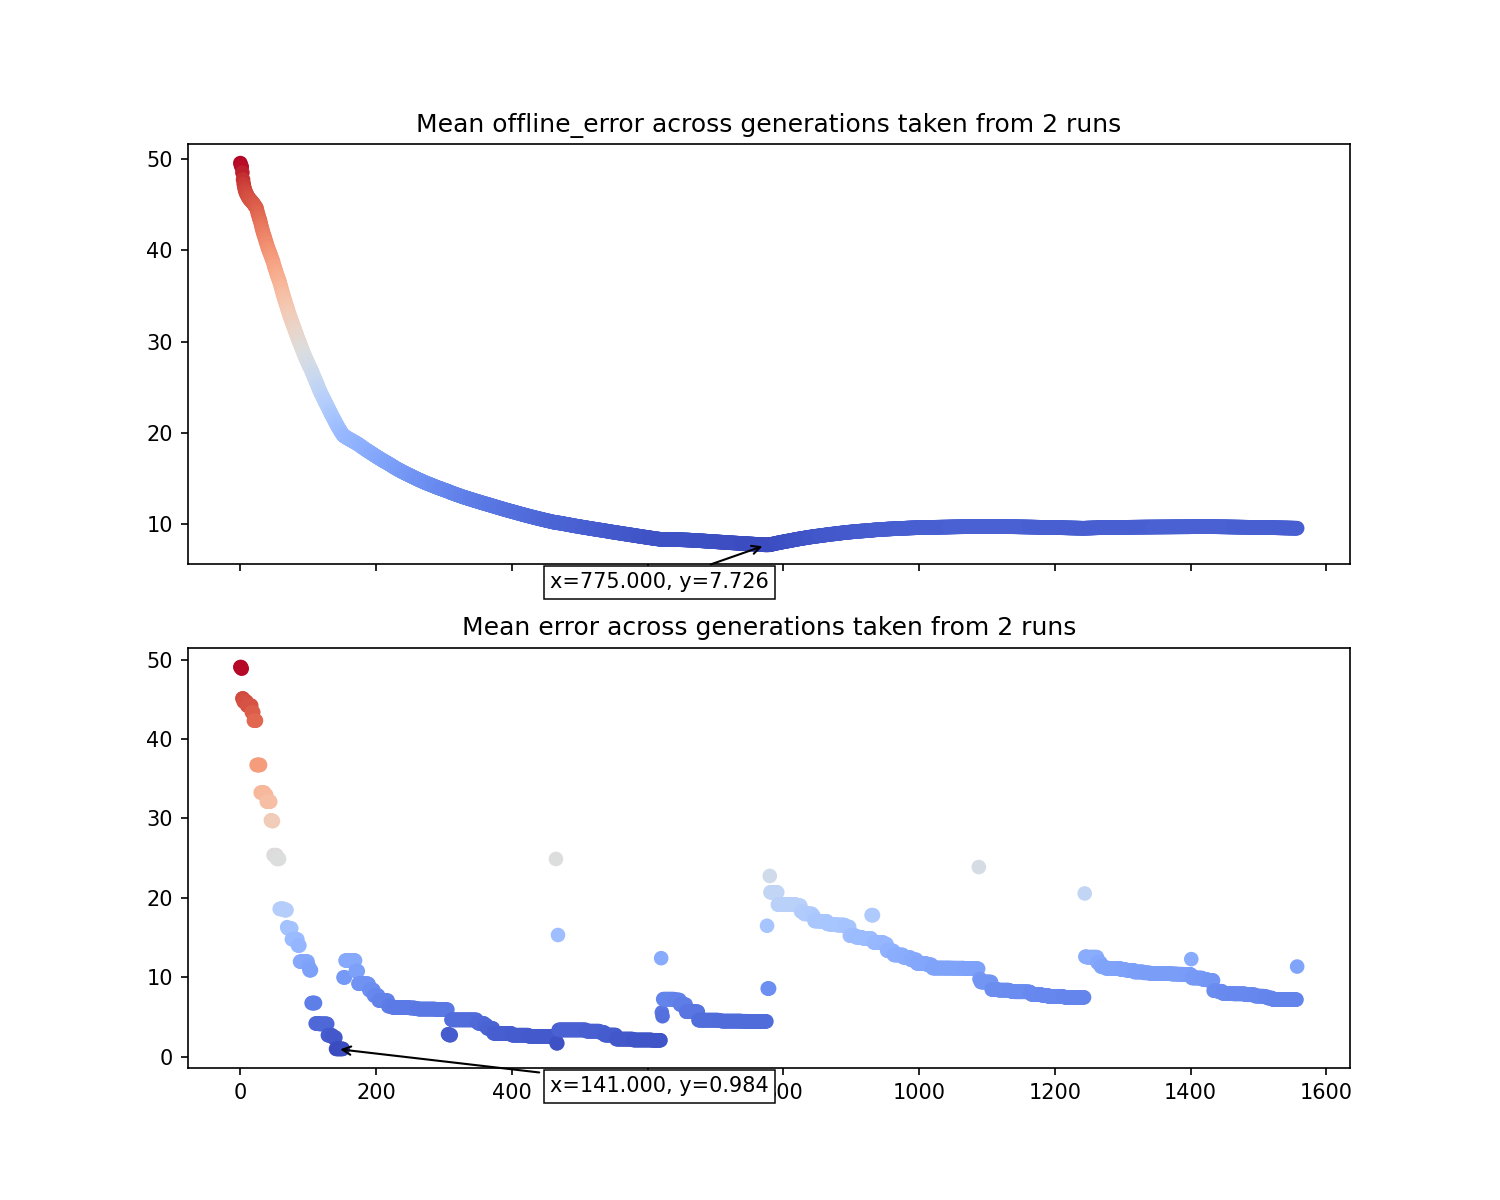

In [115]:
cfg = json.loads(json_config, object_hook = as_config)
cfg.TYPE = "MSPSO"
cfg.NSWARMS = 5
cfg.NPARTICLES = 3
run_n_times(n_runs)
cfg.NPARTICLES = 5
run_n_times(n_runs)

cfg.DIMS = 1
run_n_times(n_runs)
cfg.DIMS = 5

cfg.NSWARMS = 10
run_n_times(n_runs)
cfg.NSWARMS = 5

cfg.NEXCESS = 3
run_n_times(n_runs)
cfg.NEXCESS = 1

cfg.RCLOUD = 1
run_n_times(n_runs)
cfg.RCLOUD = 0.5

cfg.CHI = 0.6
run_n_times(n_runs)
cfg.CHI = 0.729843788

In [ ]:
cfg = json.loads(json_config, object_hook = as_config)
cfg.TYPE = "BOA"
cfg.NSWARMS = 1
cfg.NPARTICLES = 15
run_n_times(n_runs)
cfg.NPARTICLES = 30
run_n_times(n_runs)

cfg.DIMS = 1
run_n_times(n_runs)
cfg.DIMS = 5

cfg.NEXCESS = 3
run_n_times(n_runs)
cfg.NEXCESS = 1

cfg.RCLOUD = 1
run_n_times(n_runs)
cfg.RCLOUD = 0.5

cfg.CHI = 0.6
run_n_times(n_runs)
cfg.CHI = 0.729843788